In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 15)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
%matplotlib inline

In [2]:
import talib
from ta import add_all_ta_features

### Read full database

In [5]:
DATA_PATH = r'../data/'
FILE_NAME = '20220313_034756_111.pkl'
FULL_PATH = Path(DATA_PATH,FILE_NAME)

In [35]:
%time
raw = pd.read_pickle(FULL_PATH)
raw.shape

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


(5675397, 14)

In [37]:
raw.dtypes

symbol                              object
openTimets                           int64
closeTimets                          int64
openTime                    datetime64[ns]
closeTime                   datetime64[ns]
open                                object
high                                object
low                                 object
close                               object
volume                              object
numTrades                            int64
quoteAssetVolume                    object
takerBuyBaseAssetVolume             object
takerBuyQuoteAssetVolume            object
dtype: object

In [38]:
raw.symbol.value_counts()

BTCUSDT     87964
ETHUSDT     80325
BCHUSDT     78208
XRPUSDT     76486
EOSUSDT     76292
            ...  
BAKEUSDT    28582
BTTUSDT     28339
GTCUSDT     26390
TLMUSDT     23032
KEEPUSDT    22843
Name: symbol, Length: 111, dtype: int64

### Prepare and subset dataset

In [265]:
df = raw.query('symbol=="ETHUSDT"')
assert df.isnull().sum().sum() == 0
df.shape

(80325, 14)

In [266]:
# create datatypes dictionary
datatypes = {k:'float32' if k!='numTrades' else 'int32' for k in df.loc[:,'open':].columns}
# assign datatypes
df = df.astype(datatypes)
assert df.isnull().sum().sum() == 0
df.dtypes

symbol                              object
openTimets                           int64
closeTimets                          int64
openTime                    datetime64[ns]
closeTime                   datetime64[ns]
open                               float32
high                               float32
low                                float32
close                              float32
volume                             float32
numTrades                            int32
quoteAssetVolume                   float32
takerBuyBaseAssetVolume            float32
takerBuyQuoteAssetVolume           float32
dtype: object

In [268]:
df.to_pickle('../data/eth.pkl')

### Read dataset from disk

In [3]:
raw = pd.read_pickle('../data/eth.pkl')

### Group on desired frequency

In [4]:
df = \
    raw.groupby(pd.Grouper(key="openTime", freq="1H"))\
    .agg(
        cnt=pd.NamedAgg(column="symbol", aggfunc="size"),
        opentime=pd.NamedAgg(column="openTime", aggfunc="min"),
        closetime=pd.NamedAgg(column="openTime", aggfunc="min"),
        open=pd.NamedAgg(column="open", aggfunc="first"),
        high=pd.NamedAgg(column="high", aggfunc="max"),
        low=pd.NamedAgg(column="low", aggfunc="min"),
        close=pd.NamedAgg(column="close", aggfunc="last"),
        volume=pd.NamedAgg(column="volume", aggfunc="sum"),
        numtrade=pd.NamedAgg(column="numTrades", aggfunc="sum"),
    )\
    .query('cnt >= 4')\
    .drop('cnt',axis=1)\
    .assign(closetime = lambda x : x.closetime + pd.Timedelta(minutes=59))\
    .reset_index(drop=True)

# alternative way to resample and regroup data
# df = raw.resample('30min',on='opentime').agg({'close':'last','high':'max'}).tail(10)
df.tail()

,opentime,closetime,open,high,low,close,volume,numtrade
20076,2022-03-12 20:00:00,2022-03-12 20:59:00,2576.760010,2591.659912,2573.870117,2586.800049,25150.187500,35923
20077,2022-03-12 21:00:00,2022-03-12 21:59:00,2586.800049,2591.719971,2583.060059,2585.649902,13017.638672,24267
20078,2022-03-12 22:00:00,2022-03-12 22:59:00,2585.649902,2591.379883,2583.260010,2585.830078,10603.583008,26367
20079,2022-03-12 23:00:00,2022-03-12 23:59:00,2585.840088,2590.199951,2560.000000,2567.639893,35792.011719,49081
20080,2022-03-13 00:00:00,2022-03-13 00:59:00,2567.629883,2573.780029,2555.810059,2565.979980,41614.472656,50466


### Inspect Time Series

count                  20081
mean     2021-01-18 16:00:00
min      2019-11-27 08:00:00
25%      2020-06-23 12:00:00
50%      2021-01-18 16:00:00
75%      2021-08-15 20:00:00
max      2022-03-13 00:00:00
Name: opentime, dtype: object
AxesSubplot(0.125,0.125;0.775x0.755)


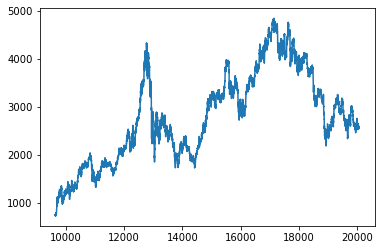

In [5]:
print(df.opentime.describe(datetime_is_numeric=True))
# print(df.close.plot())
print(df.query('opentime >= 2021').close.plot())

In [6]:
df = df.query('opentime >= 2021').copy()
df.shape

(10465, 8)

### Decompose Time Series

In [7]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
# from statsmodels.tsa.seasonal import seasonal_decompose
# # from statsmodels.tsa.seasonal import MSTL
# print(plot_acf(df.close))
# print(plot_pacf(df.close))
# # stl_kwargs = {"seasonal_deg": 0} 
# # model = MSTL(df.close, periods=(24, 24 * 7), stl_kwargs=stl_kwargs)
# # res = model.fit()
# # res.plot()

### Create Features to Avoid Leakage
> __close -> fx_close = close.shift(1)__

In [8]:
options_antileakage_feats = ['open','high','low','close','volume']
for ff in options_antileakage_feats:
    df[f'fx_{ff}'] = df[ff].shift(1)

In [9]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume'],
      dtype='object')

### Create Lag Features

In [10]:
options_lags_feats = ['close','volume']
options_lags = [1,2,3,24,48]
for ff in options_lags_feats:
    for ll in options_lags:
        df[f'fx_{ff}_lag_{str(ll).zfill(3)}'] = df[ff].shift(ll)

In [11]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048'],
      dtype='object')

In [12]:
df.shape

(10465, 23)

### Create Diff Features

In [13]:
options_diffs_feats = ['fx_close','fx_volume']
options_diffs = [1,2,3,24,48]
for ff in options_diffs_feats:
    for ll in options_diffs:
        df[f'{ff}_diff_{str(ll).zfill(3)}'] = df[ff].diff(ll)

In [14]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048', 'fx_close_diff_001', 'fx_close_diff_002',
       'fx_close_diff_003', 'fx_close_diff_024', 'fx_close_diff_048',
       'fx_volume_diff_001', 'fx_volume_diff_002', 'fx_volume_diff_003',
       'fx_volume_diff_024', 'fx_volume_diff_048'],
      dtype='object')

In [15]:
df.shape

(10465, 33)

### Create Rolling Features

In [16]:
options_wndf_feats = ['fx_close','fx_volume']
options_wndf = [24,24*7]
for ff in options_wndf_feats:
    for ll in options_wndf:
        df[f'{ff}_min_{str(ll).zfill(3)}'] = df[ff].rolling(ll).min()
        df[f'{ff}_max_{str(ll).zfill(3)}'] = df[ff].rolling(ll).max()
        df[f'{ff}_std_{str(ll).zfill(3)}'] = df[ff].rolling(ll).std()

In [17]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048', 'fx_close_diff_001', 'fx_close_diff_002',
       'fx_close_diff_003', 'fx_close_diff_024', 'fx_close_diff_048',
       'fx_volume_diff_001', 'fx_volume_diff_002', 'fx_volume_diff_003',
       'fx_volume_diff_024', 'fx_volume_diff_048', 'fx_close_min_024',
       'fx_close_max_024', 'fx_close_std_024', 'fx_close_min_168',
       'fx_close_max_168', 'fx_close_std_168', 'fx_volume_min_024',
       'fx_volume_max_024', 'fx_volume_std_024', 'fx_volume_min_168',
       'fx_volume_max_168', 'fx_volume_std_168'],
      dtype='object')

In [18]:
df.shape

(10465, 45)

### Create TA Features - Manually

In [19]:
# df = \
#     df.assign(
#         fx_sma_fast = lambda x : talib.SMA(x.close.shift(1),8),
#         fx_sma_slow = lambda x : x.close.shift(1).rolling(24).mean(),
#         fx_ema_fast = lambda x : talib.EMA(x.close.shift(1),8),
#         fx_ema_slow = lambda x : talib.EMA(x.close.shift(1),24),
#         fx_atr = lambda x : talib.ATR(x.high.shift(1),x.low.shift(1),x.close.shift(1),12),
#         fx_adx = lambda x : talib.ADX(x.high.shift(1),x.low.shift(1),x.close.shift(1),20),
#         fx_rsi = lambda x : talib.RSI(x.close.shift(1),12),
#         fx_bb_upper = lambda x : talib.BBANDS(x.close.shift(1))[0],
#         fx_bb_middle = lambda x : talib.BBANDS(x.close.shift(1))[1],
#         fx_bb_lower = lambda x : talib.BBANDS(x.close.shift(1))[2],
#     ).assign(
#         fx_sma_fast_slow_frc = lambda x : (x.fx_sma_fast/x.fx_sma_slow)
#     )
#
# df.tail(2)
# df.columns
# df.shape

### Create TA Features - Automatically

In [20]:
df = add_all_ta_features(
    df, 
    open='fx_open', 
    high='fx_high', 
    low='fx_low', 
    close='fx_close', 
    volume='fx_volume', 
    fillna=True)
df.columns

/Users/takis/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/takis/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high',
       ...
       'momentum_wr', 'momentum_ao', 'momentum_kama', 'momentum_roc',
       'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'others_dr',
       'others_dlr', 'others_cr'],
      dtype='object', length=128)

In [21]:
df = \
    df.assign(
        sma_fast_slow_frc = lambda x : (x.trend_sma_fast/x.trend_sma_slow),
        ema_fast_slow_frc = lambda x : (x.trend_ema_fast/x.trend_ema_slow)
    )

### Enable Pattern Recognition Features

In [22]:
talib.get_function_groups().keys()
# pattern_recognition_functions = [x for x in dir(talib) if x.startswith('CDL')]
pattern_recognition_functions = talib.get_function_groups().get('Pattern Recognition')
# pattern_recognition_functions[1::10]
# create pattern recognition features
pattern_features = {
    f'pt_{x.lower()}': getattr(talib,x)(df['fx_open'],df['fx_high'],df['fx_low'],df['fx_close'])
                    for x in pattern_recognition_functions
    }

In [23]:
df = df.assign(**pattern_features)
df.head(2)

,opentime,closetime,open,high,low,close,volume,...,pt_cdltakuri,pt_cdltasukigap,pt_cdlthrusting,pt_cdltristar,pt_cdlunique3river,pt_cdlupsidegap2crows,pt_cdlxsidegap3methods
9616,2021-01-01 00:00:00,2021-01-01 00:59:00,737.179993,740.000000,730.0,734.599976,98092.523438,...,0,0,0,0,0,0,0
9617,2021-01-01 01:00:00,2021-01-01 01:59:00,734.609985,750.400024,734.0,749.330017,164084.062500,...,0,0,0,0,0,0,0


In [24]:
# df[[x for x in df.columns if x.startswith('pt_')]].describe().T['mean'].plot(kind='barh',figsize=(10,15))
# df[[x for x in df.columns if x.startswith('pt_')]].describe().T

In [25]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high',
       ...
       'pt_cdlspinningtop', 'pt_cdlstalledpattern', 'pt_cdlsticksandwich',
       'pt_cdltakuri', 'pt_cdltasukigap', 'pt_cdlthrusting', 'pt_cdltristar',
       'pt_cdlunique3river', 'pt_cdlupsidegap2crows',
       'pt_cdlxsidegap3methods'],
      dtype='object', length=191)

In [26]:
df.shape

(10465, 191)

### Enable Pivot Levels

In [27]:
def PPS(high,low,close):
    if all([isinstance(item,(list,pd.core.series.Series,np.ndarray)) for item in (high,low,close)]):
        high = np.array(high,dtype='float32')
        low = np.array(low,dtype='float32')
        close = np.array(close,dtype='float32')
    else:
        raise Exception('Wrong type input data type')
    pp = (high + low + close)/3
    r1 = (2 * pp - low)
    s1 = (2 * pp - high)
    r2 = pp + high - low
    s2 = pp - high + low
    r3 = high + 2 * (pp - low)
    s3 = low - 2 * (high - pp)
    result = {'pp':pp,'r1':r1,'s1':s1,'r2':r2,'s2':s2,'r3':r3,'s3':s3}
    result = {f'fx_{k}':v for k,v in result.items()} 
    return result

In [28]:
df = df.assign(**PPS(df.fx_high,df.fx_low,df.fx_close))
df.tail(2)

,opentime,closetime,open,high,low,close,volume,...,fx_pp,fx_r1,fx_s1,fx_r2,fx_s2,fx_r3,fx_s3
20079,2022-03-12 23:00:00,2022-03-12 23:59:00,2585.840088,2590.199951,2560.000000,2567.639893,35792.011719,...,2586.823242,2590.386475,2582.266602,2594.943115,2578.703369,2598.506348,2574.146729
20080,2022-03-13 00:00:00,2022-03-13 00:59:00,2567.629883,2573.780029,2555.810059,2565.979980,41614.472656,...,2572.613281,2585.226562,2555.026611,2602.813477,2542.413330,2615.426514,2524.826660


In [29]:
df.columns[0::5]

Index(['opentime', 'close', 'fx_low', 'fx_close_lag_003', 'fx_volume_lag_003',
       'fx_close_diff_003', 'fx_volume_diff_003', 'fx_close_std_024',
       'fx_volume_max_024', 'volume_adi', 'volume_em', 'volatility_atr',
       'volatility_bbp', 'volatility_kcl', 'volatility_dcl', 'volatility_ui',
       'trend_sma_slow', 'trend_adx_neg', 'trend_mass_index', 'trend_kst_diff',
       'trend_visual_ichimoku_a', 'trend_psar_up', 'momentum_rsi',
       'momentum_uo', 'momentum_kama', 'others_dr', 'pt_cdl2crows',
       'pt_cdl3starsinsouth', 'pt_cdlbreakaway', 'pt_cdldoji',
       'pt_cdleveningstar', 'pt_cdlharami', 'pt_cdlhomingpigeon',
       'pt_cdlkickingbylength', 'pt_cdlmatchinglow', 'pt_cdlpiercing',
       'pt_cdlshortline', 'pt_cdltasukigap', 'pt_cdlxsidegap3methods',
       'fx_s2'],
      dtype='object')

In [30]:
# pd.Series(df.columns).to_clipboard()

In [31]:
df.shape

(10465, 198)

### Examine Alternative Target Options

In [32]:
chkp = df.copy()
# df = chkp.copy()

In [33]:
df = \
    df.assign(
        #change_pct = lambda x : x.close.pct_change(),
        #change_chr = lambda x : x.close.pct_change().apply(np.sign),

        trg_close_01hrs_ahead = lambda x : x.close.shift(-1),
        trg_close_04hrs_ahead = lambda x : x.close.shift(-4),
        trg_close_08hrs_ahead = lambda x : x.close.shift(-8),
        trg_close_12hrs_ahead = lambda x : x.close.shift(-12),
        trg_close_16hrs_ahead = lambda x : x.close.shift(-16),
        trg_close_20hrs_ahead = lambda x : x.close.shift(-20),
        trg_close_24hrs_ahead = lambda x : x.close.shift(-24),
        trg_close_48hrs_ahead = lambda x : x.close.shift(-48),
        trg_close_96hrs_ahead = lambda x : x.close.shift(-96),
    
        trg_delta_01hrs_ahead = lambda x : (x.close.shift(-1)/x.close)-1,
        trg_delta_04hrs_ahead = lambda x : (x.close.shift(-4)/x.close)-1,
        trg_delta_08hrs_ahead = lambda x : (x.close.shift(-8)/x.close)-1,
        trg_delta_12hrs_ahead = lambda x : (x.close.shift(-12)/x.close)-1,
        trg_delta_16hrs_ahead = lambda x : (x.close.shift(-16)/x.close)-1,
        trg_delta_20hrs_ahead = lambda x : (x.close.shift(-20)/x.close)-1,
        trg_delta_24hrs_ahead = lambda x : (x.close.shift(-24)/x.close)-1,
        trg_delta_48hrs_ahead = lambda x : (x.close.shift(-48)/x.close)-1,
        trg_delta_96hrs_ahead = lambda x : (x.close.shift(-96)/x.close)-1,
    )
df.tail(100).head(2)

,opentime,closetime,open,high,low,close,volume,...,trg_delta_08hrs_ahead,trg_delta_12hrs_ahead,trg_delta_16hrs_ahead,trg_delta_20hrs_ahead,trg_delta_24hrs_ahead,trg_delta_48hrs_ahead,trg_delta_96hrs_ahead
19981,2022-03-08 21:00:00,2022-03-08 21:59:00,2552.040039,2562.750000,2546.719971,2557.320068,38991.250000,...,0.061373,0.076518,0.066312,0.072627,0.058409,0.017542,0.011078
19982,2022-03-08 22:00:00,2022-03-08 22:59:00,2557.320068,2574.030029,2554.780029,2567.229980,29236.652344,...,0.059367,0.073601,0.066223,0.055651,0.058055,0.017034,0.007245


In [34]:
# Review distributions of absolute returns for 4-8-16 etc. hours ahead
trg_windows = [x for x in df.columns if x.startswith('trg_delta')]
for wnd in trg_windows:
    print(wnd)
    print(100*'=')
    print((pd.cut(
        x = df[wnd].abs(), 
        bins = [0, 0.025, 0.05, 0.1, 0.25, 0.5, 1.], 
        ).value_counts(normalize=True))*100)
    print(100*'-')
    print(df[wnd].apply(np.sign).value_counts(normalize=True)*100)
    print(100*'=')
    print()

trg_delta_01hrs_ahead
(0.0, 0.025]     95.698308
(0.025, 0.05]     3.861963
(0.05, 0.1]       0.430169
(0.1, 0.25]       0.009559
(0.25, 0.5]       0.000000
(0.5, 1.0]        0.000000
Name: trg_delta_01hrs_ahead, dtype: float64
----------------------------------------------------------------------------------------------------
 1.0    51.548165
-1.0    48.423165
 0.0     0.028670
Name: trg_delta_01hrs_ahead, dtype: float64

trg_delta_04hrs_ahead
(0.0, 0.025]     80.351850
(0.025, 0.05]    15.364758
(0.05, 0.1]       3.986997
(0.1, 0.25]       0.296395
(0.25, 0.5]       0.000000
(0.5, 1.0]        0.000000
Name: trg_delta_04hrs_ahead, dtype: float64
----------------------------------------------------------------------------------------------------
 1.0    52.365931
-1.0    47.614951
 0.0     0.019119
Name: trg_delta_04hrs_ahead, dtype: float64

trg_delta_08hrs_ahead
(0.0, 0.025]     67.132198
(0.025, 0.05]    22.383777
(0.05, 0.1]       9.517888
(0.1, 0.25]       0.966137
(0.25, 0.5]   

### Select Timeframe for target

In [298]:
chkp2 = df.copy()
# df = chkp2.copy()

In [299]:
my_target = 'trg_delta_24hrs_ahead'
df['target_rtrns'] = df[my_target]

In [300]:
# drop all other trg columns - i.e. time frame related targets
df = df[[x for x in df.columns if not x.startswith('trg_')]]

In [301]:
# chance to revisit/readjust bins
my_bins = [0, 0.03, 1.]
my_labels = [f'delta_{x:.0%}_{y:.0%}' for x,y in zip(my_bins[:-1],my_bins[1:])]
(pd.cut(x = df.target_rtrns.abs(), bins = my_bins, labels = my_labels).value_counts(normalize=True)*100)

delta_3%_100%    51.781609
delta_0%_3%      48.218391
Name: target_rtrns, dtype: float64

In [302]:
df['target_sign'] = df.target_rtrns.apply(np.sign)
df['target_sign_binary'] = df.target_sign.apply(lambda x : 1 if x>=0 else 0) #if na 'down' will be assigned
df['target_bins'] = pd.cut(x = df.target_rtrns.abs(), bins = my_bins, labels = my_labels)

In [303]:
df.target_bins.value_counts(dropna=False)

delta_3%_100%    5406
delta_0%_3%      5034
NaN                25
Name: target_bins, dtype: int64

In [304]:
pd.Series(
    np.where(df['target_bins']=='delta_0%_3%','steady',
        np.where(df['target_bins']=='delta_3%_100%',df['target_sign_binary'],None))
    ).value_counts(dropna=False)

steady    5034
1         3037
0         2369
NaN         25
dtype: int64

In [305]:
bins_sign = np.where(df['target_bins']=='delta_0%_3%','steady',
                     np.where(df['target_bins']=='delta_3%_100%',df['target_sign_binary'],None))
pd.DataFrame({'counts':pd.Series(bins_sign).value_counts(dropna=False),
              'normalized_counts(%)':round(pd.Series(bins_sign).value_counts(normalize=True,dropna=False)*100,2)})

,counts,normalized_counts(%)
steady,5034,48.10
1,3037,29.02
0,2369,22.64
NaN,25,0.24


In [306]:
df['target_bins_sign'] = bins_sign

In [307]:
df[[x for x in df.columns if x.startswith('target')]].isnull().sum()

target_rtrns          24
target_sign           24
target_sign_binary     0
target_bins           25
target_bins_sign      25
dtype: int64

In [308]:
df.groupby(['target_sign_binary','target_bins','target_bins_sign']).size()

target_sign_binary  target_bins    target_bins_sign
0                   delta_0%_3%    0                      0
                                   1                      0
                                   steady              2460
                    delta_3%_100%  0                   2369
                                   1                      0
                                   steady                 0
1                   delta_0%_3%    0                      0
                                   1                      0
                                   steady              2574
                    delta_3%_100%  0                      0
                                   1                   3037
                                   steady                 0
dtype: int64

### Profile Targets

In [309]:
[x for x in df.columns if x.startswith('target')]

['target_rtrns',
 'target_sign',
 'target_sign_binary',
 'target_bins',
 'target_bins_sign']

<AxesSubplot:>

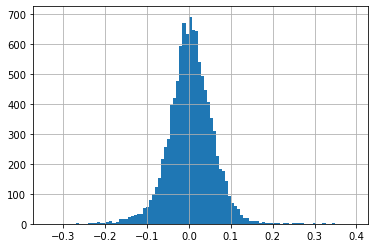

In [310]:
df.target_rtrns.hist(bins=100)

delta_3%_100%    51.781609
delta_0%_3%      48.218391
Name: target_bins, dtype: float64


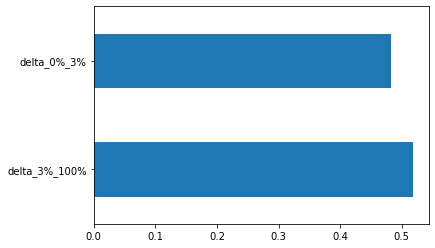

In [311]:
df.target_bins.value_counts(normalize=True).plot(kind='barh')
print(df.target_bins.value_counts(normalize=True)*100)

In [312]:
df.target_sign_binary.value_counts(normalize=True)

1    0.536264
0    0.463736
Name: target_sign_binary, dtype: float64

In [313]:
df.target_bins_sign.value_counts(normalize=True)

steady    0.482184
1         0.290900
0         0.226916
Name: target_bins_sign, dtype: float64

### Clean dataset from NAs

In [314]:
# import missingno as msno
# msno.matrix(df.set_index('opentime')[df.columns[(df.isnull().sum()!=0)]],freq='H')
from sklearn.preprocessing import LabelEncoder

In [315]:
print(f'current rows {df.shape[0]}')
print(f'max missing rows {df.isnull().sum().max()}')
print(f'opentime from {df.opentime.min().strftime("%Y-%m-%d %H:%M")} to {df.opentime.max().strftime("%Y-%m-%d %H:%M")}')

current rows 10465
max missing rows 168
opentime from 2021-01-01 00:00 to 2022-03-13 00:00


In [316]:
md = df.dropna().reset_index(drop=True).copy()
md.shape

(10272, 203)

In [317]:
print(f'remaining missing observations {md.isnull().sum().sum()}')
print(f'current rows {md.shape[0]}')
print(f'opentime from {md.opentime.min().strftime("%Y-%m-%d %H:%M")} to {md.opentime.max().strftime("%Y-%m-%d %H:%M")}')

remaining missing observations 0
current rows 10272
opentime from 2021-01-08 00:00 to 2022-03-12 00:00


In [318]:
md.target_bins_sign.value_counts()

steady    4997
1         2920
0         2355
Name: target_bins_sign, dtype: int64

In [319]:
X = md[[x for x in md.columns if not (x.startswith('target') | x.endswith('time'))]].reset_index(drop=True)
X = X.drop(['open','high','low','close','volume','numtrade'],axis=1)

In [320]:
[x for x in md.columns if x.startswith('target')]

['target_rtrns',
 'target_sign',
 'target_sign_binary',
 'target_bins',
 'target_bins_sign']

In [321]:
y = md['target_sign_binary']

In [322]:
# pd.Series(md.columns).to_clipboard()
# pd.Series(X.columns).to_clipboard()

### Temporal Train Test Split - dataset to test at the end

In [323]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [324]:
y, y_keep, X, X_keep = temporal_train_test_split(y,X,test_size=24*7*4)

In [325]:
[x.shape for x in [y, y_keep, X, X_keep]]

[(9600,), (672,), (9600, 190), (672, 190)]

In [326]:
y_keep.value_counts()

0    385
1    287
Name: target_sign_binary, dtype: int64

### Setup Cross-Validation

In [327]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter

### sklearn TimeSeriesSplit

In [328]:
# # tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=200)
# tscv = TimeSeriesSplit(n_splits=10)
# for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
#     print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
#     X_train, X_test = X.loc[train_index], X.loc[test_index]
#     y_train, y_test = y[train_index], y.loc[test_index]

In [329]:
def TimeSeriesCV(X,y,n_splits=20, gap=0, max_train_size=None, test_size=None, verbose=False):
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap, max_train_size=max_train_size, test_size=test_size)
    for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y.loc[test_index]
        
        if verbose:
            print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
            #print('\nEVENT RATIO in TRAIN')
            #print(y_train.value_counts(normalize=True)*100)
            #print('\nEVENT RATIO in TEST')
            #print(y_test.value_counts(normalize=True)*100)
            #print('-'*100)
            #print()
            
        yield (X_train,y_train,X_test,y_test)

In [330]:
tscv = TimeSeriesCV(X,y,n_splits=24*7*4,test_size=1,max_train_size=5000,verbose=True)
for xx in tscv:
    X_train,y_train,X_test,y_test = xx

(01) train : 3928-8927 [5000] & test 8928-8928 [1]
(02) train : 3929-8928 [5000] & test 8929-8929 [1]
(03) train : 3930-8929 [5000] & test 8930-8930 [1]
(04) train : 3931-8930 [5000] & test 8931-8931 [1]
(05) train : 3932-8931 [5000] & test 8932-8932 [1]
(06) train : 3933-8932 [5000] & test 8933-8933 [1]
(07) train : 3934-8933 [5000] & test 8934-8934 [1]
(08) train : 3935-8934 [5000] & test 8935-8935 [1]
(09) train : 3936-8935 [5000] & test 8936-8936 [1]
(10) train : 3937-8936 [5000] & test 8937-8937 [1]
(11) train : 3938-8937 [5000] & test 8938-8938 [1]
(12) train : 3939-8938 [5000] & test 8939-8939 [1]
(13) train : 3940-8939 [5000] & test 8940-8940 [1]
(14) train : 3941-8940 [5000] & test 8941-8941 [1]
(15) train : 3942-8941 [5000] & test 8942-8942 [1]
(16) train : 3943-8942 [5000] & test 8943-8943 [1]
(17) train : 3944-8943 [5000] & test 8944-8944 [1]
(18) train : 3945-8944 [5000] & test 8945-8945 [1]
(19) train : 3946-8945 [5000] & test 8946-8946 [1]
(20) train : 3947-8946 [5000] &

(244) train : 4171-9170 [5000] & test 9171-9171 [1]
(245) train : 4172-9171 [5000] & test 9172-9172 [1]
(246) train : 4173-9172 [5000] & test 9173-9173 [1]
(247) train : 4174-9173 [5000] & test 9174-9174 [1]
(248) train : 4175-9174 [5000] & test 9175-9175 [1]
(249) train : 4176-9175 [5000] & test 9176-9176 [1]
(250) train : 4177-9176 [5000] & test 9177-9177 [1]
(251) train : 4178-9177 [5000] & test 9178-9178 [1]
(252) train : 4179-9178 [5000] & test 9179-9179 [1]
(253) train : 4180-9179 [5000] & test 9180-9180 [1]
(254) train : 4181-9180 [5000] & test 9181-9181 [1]
(255) train : 4182-9181 [5000] & test 9182-9182 [1]
(256) train : 4183-9182 [5000] & test 9183-9183 [1]
(257) train : 4184-9183 [5000] & test 9184-9184 [1]
(258) train : 4185-9184 [5000] & test 9185-9185 [1]
(259) train : 4186-9185 [5000] & test 9186-9186 [1]
(260) train : 4187-9186 [5000] & test 9187-9187 [1]
(261) train : 4188-9187 [5000] & test 9188-9188 [1]
(262) train : 4189-9188 [5000] & test 9189-9189 [1]
(263) train 

(514) train : 4441-9440 [5000] & test 9441-9441 [1]
(515) train : 4442-9441 [5000] & test 9442-9442 [1]
(516) train : 4443-9442 [5000] & test 9443-9443 [1]
(517) train : 4444-9443 [5000] & test 9444-9444 [1]
(518) train : 4445-9444 [5000] & test 9445-9445 [1]
(519) train : 4446-9445 [5000] & test 9446-9446 [1]
(520) train : 4447-9446 [5000] & test 9447-9447 [1]
(521) train : 4448-9447 [5000] & test 9448-9448 [1]
(522) train : 4449-9448 [5000] & test 9449-9449 [1]
(523) train : 4450-9449 [5000] & test 9450-9450 [1]
(524) train : 4451-9450 [5000] & test 9451-9451 [1]
(525) train : 4452-9451 [5000] & test 9452-9452 [1]
(526) train : 4453-9452 [5000] & test 9453-9453 [1]
(527) train : 4454-9453 [5000] & test 9454-9454 [1]
(528) train : 4455-9454 [5000] & test 9455-9455 [1]
(529) train : 4456-9455 [5000] & test 9456-9456 [1]
(530) train : 4457-9456 [5000] & test 9457-9457 [1]
(531) train : 4458-9457 [5000] & test 9458-9458 [1]
(532) train : 4459-9458 [5000] & test 9459-9459 [1]
(533) train 

In [331]:
tscv = TimeSeriesCV(X,y,n_splits=24*7*4,test_size=1,max_train_size=5000,verbose=True)

In [332]:
# # the tscv object yields n_splits dataset everytime 'next' is used
# # this will yield as many (n_splits) datasets there are and then it will prompt an error
# X_train,y_train,X_test,y_test = next(tscv)
# [len(x) for x in [X_train,y_train,X_test,y_test]]
# X_train.tail()

### sktime SlidingWindowSplitter

In [246]:
tscv = SlidingWindowSplitter(window_length=3500, fh=list(range(1,(200+1))), step_length=1000)
n_splits = tscv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
    print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y.loc[test_index]

Number of Folds = 6
(01) train : 0-3499 [3500] & test 3500-3699 [200]
(02) train : 1000-4499 [3500] & test 4500-4699 [200]
(03) train : 2000-5499 [3500] & test 5500-5699 [200]
(04) train : 3000-6499 [3500] & test 6500-6699 [200]
(05) train : 4000-7499 [3500] & test 7500-7699 [200]
(06) train : 5000-8499 [3500] & test 8500-8699 [200]


In [247]:
def SlidingCV(X,y,window_length=1000, fh=list(range(1,(200+1))), step_length=1000, verbose=False):
    tscv = SlidingWindowSplitter(window_length=window_length, fh=fh, step_length=step_length)
    for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y.loc[test_index]
        
        if verbose:
            print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
            #print('\nEVENT RATIO in TRAIN')
            #print(y_train.value_counts(normalize=True)*100)
            #print('\nEVENT RATIO in TEST')
            #print(y_test.value_counts(normalize=True)*100)
            #print('-'*100)
            #print()
            
        yield (X_train,y_train,X_test,y_test)

In [288]:
tscv = SlidingCV(X,y,window_length=3500, fh=list(range(1,(200+1))), step_length=500, verbose=True)
for xx in tscv:
    X_train,y_train,X_test,y_test = xx

(01) train : 0-3499 [3500] & test 3500-3699 [200]
(02) train : 500-3999 [3500] & test 4000-4199 [200]
(03) train : 1000-4499 [3500] & test 4500-4699 [200]
(04) train : 1500-4999 [3500] & test 5000-5199 [200]
(05) train : 2000-5499 [3500] & test 5500-5699 [200]
(06) train : 2500-5999 [3500] & test 6000-6199 [200]
(07) train : 3000-6499 [3500] & test 6500-6699 [200]
(08) train : 3500-6999 [3500] & test 7000-7199 [200]
(09) train : 4000-7499 [3500] & test 7500-7699 [200]
(10) train : 4500-7999 [3500] & test 8000-8199 [200]
(11) train : 5000-8499 [3500] & test 8500-8699 [200]


### sktime ExpandingWindowSplitter

In [249]:
tscv = ExpandingWindowSplitter(fh=list(range(1,(200+1))), step_length=1000)
n_splits = tscv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
    print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y.loc[test_index]

Number of Folds = 9
(01) train : 0-9 [10] & test 10-209 [200]
(02) train : 0-1009 [1010] & test 1010-1209 [200]
(03) train : 0-2009 [2010] & test 2010-2209 [200]
(04) train : 0-3009 [3010] & test 3010-3209 [200]
(05) train : 0-4009 [4010] & test 4010-4209 [200]
(06) train : 0-5009 [5010] & test 5010-5209 [200]
(07) train : 0-6009 [6010] & test 6010-6209 [200]
(08) train : 0-7009 [7010] & test 7010-7209 [200]
(09) train : 0-8009 [8010] & test 8010-8209 [200]


In [250]:
def ExpandingCV(X,y,fh=list(range(1,(200+1))), step_length=1000, verbose=False):
    tscv = ExpandingWindowSplitter(fh=fh, step_length=step_length)
    for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y.loc[test_index]
        
        if verbose:
            print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
            #print('\nEVENT RATIO in TRAIN')
            #print(y_train.value_counts(normalize=True)*100)
            #print('\nEVENT RATIO in TEST')
            #print(y_test.value_counts(normalize=True)*100)
            #print('-'*100)
            #print()
            
        yield (X_train,y_train,X_test,y_test)

In [251]:
tscv = ExpandingCV(X,y,verbose=True)
for xx in tscv:
    X_train,y_train,X_test,y_test = xx

(01) train : 0-9 [10] & test 10-209 [200]
(02) train : 0-1009 [1010] & test 1010-1209 [200]
(03) train : 0-2009 [2010] & test 2010-2209 [200]
(04) train : 0-3009 [3010] & test 3010-3209 [200]
(05) train : 0-4009 [4010] & test 4010-4209 [200]
(06) train : 0-5009 [5010] & test 5010-5209 [200]
(07) train : 0-6009 [6010] & test 6010-6209 [200]
(08) train : 0-7009 [7010] & test 7010-7209 [200]
(09) train : 0-8009 [8010] & test 8010-8209 [200]


### Model Training - Across all Folds

In [333]:
from tqdm import tqdm

In [356]:
%time
SPLITS = 100 #24*7*4
# tscv = TimeSeriesCV(X,y,n_splits=10,test_size=24*7*4,verbose=True)
# tscv = SlidingCV(X,y,window_length=3500, fh=list(range(1,(200+1))), step_length=500, verbose=True)
tscv = TimeSeriesCV(X,y,n_splits=SPLITS,test_size=1,max_train_size=5000,verbose=True)

y_true = []
y_preds_list = []
y_probs_list = []
featimp_list = []

for foo in tqdm(tscv):
    
    X_train,y_train,X_test,y_test = foo
    
    clf = LGBMClassifier(
        #class_weight='balanced',
        boosting_type='dart',
        #colsample_bytree=np.sqrt(X.shape[1])/(X.shape[1]),
        n_estimators=500,
        objective='binary',
        n_jobs=-1
        )
    
    clf.fit(X_train,y_train)
    y_preds_list.append(clf.predict(X_test))
    y_probs_list.append(clf.predict_proba(X_test))
    y_true.append(y_test)
    
    featimp_list.append(pd.DataFrame({'features':X_train.columns,'importance':clf.feature_importances_}))
    
    print(100*'=')

0it [00:00, ?it/s]

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs
(01) train : 4500-9499 [5000] & test 9500-9500 [1]


1it [00:08,  8.66s/it]

(02) train : 4501-9500 [5000] & test 9501-9501 [1]


2it [00:16,  8.45s/it]

(03) train : 4502-9501 [5000] & test 9502-9502 [1]


3it [00:25,  8.38s/it]

(04) train : 4503-9502 [5000] & test 9503-9503 [1]


4it [00:33,  8.38s/it]

(05) train : 4504-9503 [5000] & test 9504-9504 [1]


5it [00:42,  8.47s/it]

(06) train : 4505-9504 [5000] & test 9505-9505 [1]


6it [00:50,  8.51s/it]

(07) train : 4506-9505 [5000] & test 9506-9506 [1]


7it [00:59,  8.53s/it]

(08) train : 4507-9506 [5000] & test 9507-9507 [1]


8it [01:08,  8.57s/it]

(09) train : 4508-9507 [5000] & test 9508-9508 [1]


9it [01:16,  8.50s/it]

(10) train : 4509-9508 [5000] & test 9509-9509 [1]


10it [01:24,  8.52s/it]

(11) train : 4510-9509 [5000] & test 9510-9510 [1]


11it [01:33,  8.47s/it]

(12) train : 4511-9510 [5000] & test 9511-9511 [1]


12it [01:41,  8.48s/it]

(13) train : 4512-9511 [5000] & test 9512-9512 [1]


13it [01:50,  8.46s/it]

(14) train : 4513-9512 [5000] & test 9513-9513 [1]


14it [01:58,  8.41s/it]

(15) train : 4514-9513 [5000] & test 9514-9514 [1]


15it [02:07,  8.44s/it]

(16) train : 4515-9514 [5000] & test 9515-9515 [1]


16it [02:15,  8.41s/it]

(17) train : 4516-9515 [5000] & test 9516-9516 [1]


17it [02:23,  8.45s/it]

(18) train : 4517-9516 [5000] & test 9517-9517 [1]


18it [02:32,  8.45s/it]

(19) train : 4518-9517 [5000] & test 9518-9518 [1]


19it [02:40,  8.44s/it]

(20) train : 4519-9518 [5000] & test 9519-9519 [1]


20it [02:49,  8.47s/it]

(21) train : 4520-9519 [5000] & test 9520-9520 [1]


21it [02:57,  8.49s/it]

(22) train : 4521-9520 [5000] & test 9521-9521 [1]


22it [03:06,  8.55s/it]

(23) train : 4522-9521 [5000] & test 9522-9522 [1]


23it [03:15,  8.62s/it]

(24) train : 4523-9522 [5000] & test 9523-9523 [1]


24it [03:24,  8.63s/it]

(25) train : 4524-9523 [5000] & test 9524-9524 [1]


25it [03:32,  8.56s/it]

(26) train : 4525-9524 [5000] & test 9525-9525 [1]


26it [03:40,  8.56s/it]

(27) train : 4526-9525 [5000] & test 9526-9526 [1]


27it [03:49,  8.57s/it]

(28) train : 4527-9526 [5000] & test 9527-9527 [1]


28it [03:58,  8.55s/it]

(29) train : 4528-9527 [5000] & test 9528-9528 [1]


29it [04:06,  8.50s/it]

(30) train : 4529-9528 [5000] & test 9529-9529 [1]


30it [04:14,  8.47s/it]

(31) train : 4530-9529 [5000] & test 9530-9530 [1]


31it [04:23,  8.52s/it]

(32) train : 4531-9530 [5000] & test 9531-9531 [1]


32it [04:32,  8.53s/it]

(33) train : 4532-9531 [5000] & test 9532-9532 [1]


33it [04:40,  8.60s/it]

(34) train : 4533-9532 [5000] & test 9533-9533 [1]


34it [04:49,  8.56s/it]

(35) train : 4534-9533 [5000] & test 9534-9534 [1]


35it [04:57,  8.50s/it]

(36) train : 4535-9534 [5000] & test 9535-9535 [1]


36it [05:05,  8.45s/it]

(37) train : 4536-9535 [5000] & test 9536-9536 [1]


37it [05:14,  8.43s/it]

(38) train : 4537-9536 [5000] & test 9537-9537 [1]


38it [05:22,  8.41s/it]

(39) train : 4538-9537 [5000] & test 9538-9538 [1]


39it [05:31,  8.39s/it]

(40) train : 4539-9538 [5000] & test 9539-9539 [1]


40it [05:39,  8.35s/it]

(41) train : 4540-9539 [5000] & test 9540-9540 [1]


41it [05:47,  8.35s/it]

(42) train : 4541-9540 [5000] & test 9541-9541 [1]


42it [05:55,  8.34s/it]

(43) train : 4542-9541 [5000] & test 9542-9542 [1]


43it [06:04,  8.35s/it]

(44) train : 4543-9542 [5000] & test 9543-9543 [1]


44it [06:12,  8.33s/it]

(45) train : 4544-9543 [5000] & test 9544-9544 [1]


45it [06:20,  8.33s/it]

(46) train : 4545-9544 [5000] & test 9545-9545 [1]


46it [06:29,  8.33s/it]

(47) train : 4546-9545 [5000] & test 9546-9546 [1]


47it [06:37,  8.33s/it]

(48) train : 4547-9546 [5000] & test 9547-9547 [1]


48it [06:45,  8.32s/it]

(49) train : 4548-9547 [5000] & test 9548-9548 [1]


49it [06:54,  8.33s/it]

(50) train : 4549-9548 [5000] & test 9549-9549 [1]


50it [07:02,  8.33s/it]

(51) train : 4550-9549 [5000] & test 9550-9550 [1]


51it [07:11,  8.35s/it]

(52) train : 4551-9550 [5000] & test 9551-9551 [1]


52it [07:19,  8.34s/it]

(53) train : 4552-9551 [5000] & test 9552-9552 [1]


53it [07:27,  8.33s/it]

(54) train : 4553-9552 [5000] & test 9553-9553 [1]


54it [07:35,  8.33s/it]

(55) train : 4554-9553 [5000] & test 9554-9554 [1]


55it [07:44,  8.33s/it]

(56) train : 4555-9554 [5000] & test 9555-9555 [1]


56it [07:52,  8.30s/it]

(57) train : 4556-9555 [5000] & test 9556-9556 [1]


57it [08:00,  8.32s/it]

(58) train : 4557-9556 [5000] & test 9557-9557 [1]


58it [08:09,  8.39s/it]

(59) train : 4558-9557 [5000] & test 9558-9558 [1]


59it [08:18,  8.51s/it]

(60) train : 4559-9558 [5000] & test 9559-9559 [1]


60it [08:27,  8.59s/it]

(61) train : 4560-9559 [5000] & test 9560-9560 [1]


61it [08:35,  8.51s/it]

(62) train : 4561-9560 [5000] & test 9561-9561 [1]


62it [08:43,  8.50s/it]

(63) train : 4562-9561 [5000] & test 9562-9562 [1]


63it [08:52,  8.52s/it]

(64) train : 4563-9562 [5000] & test 9563-9563 [1]


64it [09:00,  8.45s/it]

(65) train : 4564-9563 [5000] & test 9564-9564 [1]


65it [09:08,  8.40s/it]

(66) train : 4565-9564 [5000] & test 9565-9565 [1]


66it [09:17,  8.43s/it]

(67) train : 4566-9565 [5000] & test 9566-9566 [1]


67it [09:25,  8.40s/it]

(68) train : 4567-9566 [5000] & test 9567-9567 [1]


68it [09:34,  8.39s/it]

(69) train : 4568-9567 [5000] & test 9568-9568 [1]


69it [09:42,  8.42s/it]

(70) train : 4569-9568 [5000] & test 9569-9569 [1]


70it [09:51,  8.47s/it]

(71) train : 4570-9569 [5000] & test 9570-9570 [1]


71it [09:59,  8.45s/it]

(72) train : 4571-9570 [5000] & test 9571-9571 [1]


72it [10:07,  8.40s/it]

(73) train : 4572-9571 [5000] & test 9572-9572 [1]


73it [10:16,  8.36s/it]

(74) train : 4573-9572 [5000] & test 9573-9573 [1]


74it [10:24,  8.39s/it]

(75) train : 4574-9573 [5000] & test 9574-9574 [1]


75it [10:32,  8.36s/it]

(76) train : 4575-9574 [5000] & test 9575-9575 [1]


76it [10:41,  8.36s/it]

(77) train : 4576-9575 [5000] & test 9576-9576 [1]


77it [10:49,  8.40s/it]

(78) train : 4577-9576 [5000] & test 9577-9577 [1]


78it [10:58,  8.37s/it]

(79) train : 4578-9577 [5000] & test 9578-9578 [1]


79it [11:06,  8.34s/it]

(80) train : 4579-9578 [5000] & test 9579-9579 [1]


80it [11:14,  8.33s/it]

(81) train : 4580-9579 [5000] & test 9580-9580 [1]


81it [11:23,  8.37s/it]

(82) train : 4581-9580 [5000] & test 9581-9581 [1]


82it [11:31,  8.35s/it]

(83) train : 4582-9581 [5000] & test 9582-9582 [1]


83it [11:39,  8.35s/it]

(84) train : 4583-9582 [5000] & test 9583-9583 [1]


84it [11:48,  8.38s/it]

(85) train : 4584-9583 [5000] & test 9584-9584 [1]


85it [11:56,  8.41s/it]

(86) train : 4585-9584 [5000] & test 9585-9585 [1]


86it [12:05,  8.39s/it]

(87) train : 4586-9585 [5000] & test 9586-9586 [1]


87it [12:13,  8.36s/it]

(88) train : 4587-9586 [5000] & test 9587-9587 [1]


88it [12:21,  8.34s/it]

(89) train : 4588-9587 [5000] & test 9588-9588 [1]


89it [12:29,  8.35s/it]

(90) train : 4589-9588 [5000] & test 9589-9589 [1]


90it [12:38,  8.35s/it]

(91) train : 4590-9589 [5000] & test 9590-9590 [1]


91it [12:46,  8.36s/it]

(92) train : 4591-9590 [5000] & test 9591-9591 [1]


92it [12:54,  8.32s/it]

(93) train : 4592-9591 [5000] & test 9592-9592 [1]


93it [13:03,  8.32s/it]

(94) train : 4593-9592 [5000] & test 9593-9593 [1]


94it [13:11,  8.29s/it]

(95) train : 4594-9593 [5000] & test 9594-9594 [1]


95it [13:19,  8.28s/it]

(96) train : 4595-9594 [5000] & test 9595-9595 [1]


96it [13:27,  8.25s/it]

(97) train : 4596-9595 [5000] & test 9596-9596 [1]


97it [13:36,  8.24s/it]

(98) train : 4597-9596 [5000] & test 9597-9597 [1]


98it [13:44,  8.22s/it]

(99) train : 4598-9597 [5000] & test 9598-9598 [1]


99it [13:52,  8.18s/it]

(100) train : 4599-9598 [5000] & test 9599-9599 [1]


100it [14:00,  8.41s/it]

In [379]:
res = pd.DataFrame({'actual':[x.values[0] for x in y_true],
                    'preds':[x[0] for x in y_preds_list],
                    'probs':[x[0][1] for x in y_probs_list]})
res

,actual,preds,probs
0,0,0,0.147572
1,0,0,0.058591
2,0,0,0.079712
3,0,0,0.120026
4,0,0,0.102514
...,...,...,...
95,1,0,0.394481
96,0,1,0.798020
97,1,0,0.492740
98,0,1,0.665355


In [388]:
res.groupby(['actual'])['probs'].describe()

,count,mean,std,min,25%,50%,75%,max
actual,,,,,,,,
0,66.0,0.214464,0.200496,0.013106,0.079814,0.133502,0.313027,0.803063
1,34.0,0.778879,0.212038,0.144361,0.730219,0.828836,0.920878,0.978062


In [381]:
accuracy_score(res.actual,res.preds)

0.89

In [382]:
roc_auc_score(res.actual,res.preds)

0.8881461675579322

In [383]:
print(classification_report(res.actual,res.preds))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        66
           1       0.81      0.88      0.85        34

    accuracy                           0.89       100
   macro avg       0.87      0.89      0.88       100
weighted avg       0.89      0.89      0.89       100



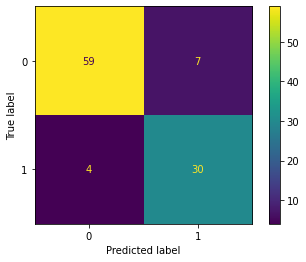

In [384]:
cm = confusion_matrix(res.actual,res.preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

<AxesSubplot:ylabel='features'>

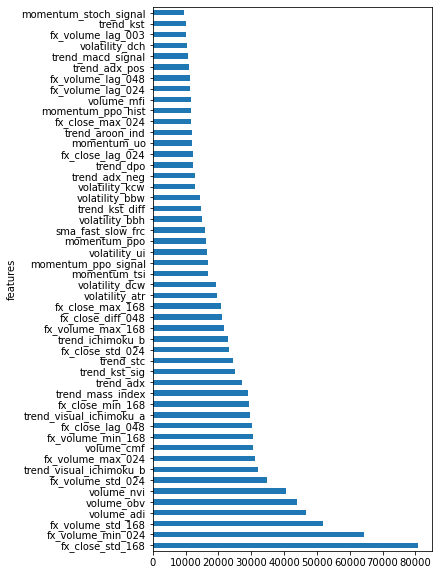

In [377]:
pd.concat(featimp_list)\
    .groupby(['features'])['importance'].sum()\
    .sort_values(ascending=False)\
    .head(50)\
    .plot(kind='barh',figsize=(5,10))

### Evaluation scikit-plot

In [391]:
import scikitplot as skplt

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

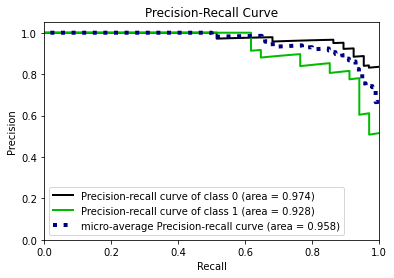

In [395]:
skplt.metrics.plot_precision_recall_curve(res.actual, [x[0] for x in y_probs_list])

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

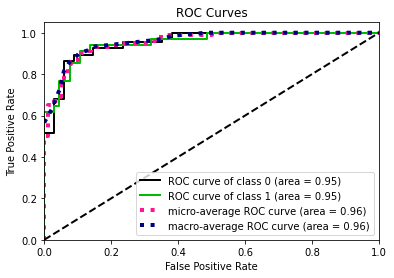

In [397]:
skplt.metrics.plot_roc(res.actual, [x[0] for x in y_probs_list])

<AxesSubplot:title={'center':'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

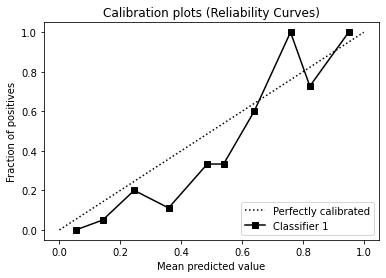

In [403]:
skplt.metrics.plot_calibration_curve(res.actual, [[x[0] for x in y_probs_list]])